# Lab 3: Multi-modal and Multi-task

**Group Members:**
* Clay Harper
* Eli Laird

In this report, we were to choose a dataset where a multi-modal model (multiple input streams), multi-task model (multiple predictive tasks), or both could be created.  We decided to use the 2018 OpenMic dataset because some of Clay's research is based in audio processing, and Eli has in interest in breaking into this field.  

## Dataset Overview

The 2018 OpenMic dataset [1] was created in a collaboration effort between Spotify and MARL@NYU (Music and Audio Research Laboratory New York University).

### Classification Task

The classification task is to determine what instruments are present in the audio clip.  Each audio clip may contain multiple instruments, so the task is to determine all instruments present in the clip.  The classification labels are:

* accordion
* banjo
* bass
* cello
* clarinet
* cymbals
* drums
* flute
* guitar
* mallet_percussion
* mandolin
* organ
* piano
* saxophone,
* synthesizer
* trombone
* trumpet
* ukulele
* violin
* voice

Each audio clip has been labeled by a variety of people on which instruments are present in the clip.  Each person, depending on their area of expertise, is given a `worker_trust` score--so a piano player will get a high trust on identifying if there is a piano but maybe a lower trust in identifying a ukulele.  From that, a `relevance_score` is computed by a weighted sum of the `worker_trust` and the `label` (1 or 0) if the instrument was present.  Essentially, each audio clip is given a `relevance_score` for each instrument.  `relevance_score` is basically a confidence score for how likely this instrument appears in the audio clip.

### Feature Data Format

There are multiple options we can do for the feature data.  The data archive includes both raw audio files in the form of `.ogg` files and pre-computed VGGish Features [3].  If we wanted, we could featurize of the `.ogg` files by using the raw amplitude values, use MFCCs, CQT, etc.  For simplicity in this lab, we have decided to just use the VGGish features provided.   


### Mulit-Modal/Multi-Task/Both?

We decided to add another modality into the network in order to make this project both multi-task and multi-modal.  This project is muli-task where the tasks are identifying each instrument in the audio clip separately, and the modalities are the VGGish features along with MFCCs for each audio clip.

### Who Collected the Data?

Spotify and MARL@NYU (Music and Audio Research Laboratory New York University).  The cost of annotation was sponsored by Spotify.

#### Why was the Data Collected?

The idea was to create a dataset that can be used in music information retrieval through identifying different instruments in an audio clip.  Some applications of music information retrieval are music genre classification, recommender systems, music separation, automatic music transcription, music generation, and more [2]. To give an example of how this dataset could help Spotify, think of a user who wants to listen to piano music on a long day.  The user could go to the search bar on Spotify and type in piano.  In order to get good results, the Spotify must have piano tags associated with songs to return piano music.  This process of tagging can be very labor intensive and expensive because people have to listen to a song, identify it as piano music, and tag the song in the database.  This is increasingly difficult when more songs are constantly added to Spotify's database.  Instead, if we can create a model that is very good at listening to music and segmenting out the types of instruments in the music, we can help automate this process (also VGGish was developed by Google so...).  VGGish features are computed using a pre-trained CNN from Google based on [3], which essentially uses a very similar architecture to the VGG image classification architecture.  In total, there are 17 layers containing convolutional layers, activations, followed by maxpooling operations.  In the OpenMic version, VGGish Features are computed on an embedding layer in the VGGish archtitecture and then projected down to a _____ dimensional space using PCA. 

#### When was the Data Collected?

The data was collected and put together in 2018.

### Evaluation Criteria

We thought about discretizing the `relevance_score` by some threshold (say .5) and making this a binary classification problem for each instrument.  Instead, we decided to regress the `relevance_score` for each instrument because this allows for more post-processing, particularly in an example discussed above with a user searching for piano music.  If we used a threshold of .5, a `relevance_score` of .51 would mean that, yes, a piano appears in this audio clip.  Well, maybe the piano just appears for a breif amount of time in the audio clip and that's why it had a relatively low confidence score.  The user searching for piano music would likely want songs that are very piano-based--that's why they probably searched `piano`.  Regressing the relevance score instead would allow better post-processing where maybe we can sort the search results from highest to lowest `relevance_score` so the user is happier with the search results.

Because we are regressing `relevance_score`, we will be using mean-squared error (MSE) as our evaluation criteria along with mean absolute error (MAE) for human interpretability.  Although MAE is easier to interpret because it is in the same units as the labeled data, it doesn't penalize large errors more heavily like MSE.  Because of this, we are optimizing using MSE, but we will also report the MAE.

 


[1] Humphrey, Eric J., Durand, Simon, and McFee, Brian. "OpenMIC-2018: An Open Dataset for Multiple Instrument Recognition." in Proceedings of the 19th International Society for Music Information Retrieval Conference (ISMIR), 2018.

[2] https://en.wikipedia.org/wiki/Music_information_retrieval#:~:text=Music%20information%20retrieval%20(MIR)%20is,with%20many%20real%2Dworld%20applications.

[3] Shawn Hershey, Sourish Chaudhuri, Daniel P. W. Ellis, Jort F. Gemmeke, Aren Jansen, Channing Moore, Manoj Plakal, Devin Platt, Rif A. Saurous, Bryan Seybold, Malcolm Slaney, Ron Weiss, & Kevin Wilson (2017). CNN Architectures for Large-Scale Audio Classification. In International Conference on Acoustics, Speech and Signal Processing (ICASSP).

## How many tasks or modalities are there in the dataset and how do you define each task or modality?

There are 20 tasks (1 for each instrument), and there are 2 modalities--the VGGish Feature and normalized MFCCs.  

****domains/cross domains

**BEWARE**
* TF2.0.0 isn't compatable with python > 3.7
* Must use TF2.0.0 for maneframe

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, ShuffleSplit
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("TF Version: ", tf.__version__)

TF Version:  2.0.0


In [3]:
datadir = './data'
openmic_file_dir = os.path.join(datadir, 'openmic-2018')

## Load In Data

In [4]:
with np.load(os.path.join(openmic_file_dir, 'openmic-2018.npz'), allow_pickle=True) as data:
    files = data.files
    print(f'The data files are: {files}')
    
    x_total = data['X']
    y = data['Y_true']
    y[y == .5] = 0 # weird dataset (.5 only occurs with their 50/50 shot--not ever a relevance score)
    # Call it a soft-no since it appears in the individual df but not in the label df
    y_mask = data['Y_mask']
    sample_keys = data['sample_key']

print(f'Data shape: {x_total.shape}')
print(f'True label shape: {y.shape}')
print(f'True label mask shape: {y_mask.shape}')
print(f'Total samples: {sample_keys.shape}')

with open(os.path.join(openmic_file_dir, 'class-map.json'), 'r') as f:
    class_map = json.load(f)
class_map

The data files are: ['X', 'Y_true', 'Y_mask', 'sample_key']
Data shape: (20000, 10, 128)
True label shape: (20000, 20)
True label mask shape: (20000, 20)
Total samples: (20000,)


{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

### Split Into Train/Test

**We can talk about this more later, could do 80/20 split-probably should do cross validation**

**Using their split for now**

**Well,...they have their own split.  Not sure if this is what Dr. Larson wants though**

* Should be useful:
    * https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb

In [5]:
# If we use their split
split_train = pd.read_csv(os.path.join(openmic_file_dir, 'partitions/split01_train.csv'), 
                          header=None, squeeze=True)
split_test = pd.read_csv(os.path.join(openmic_file_dir,'partitions/split01_test.csv'), 
                         header=None, squeeze=True)

print(f'Train samples: {len(split_train)} test samples: {len(split_test)}')

Train samples: 14915 test samples: 5085


In [6]:
split_test[0]

'000178_3840'

In [7]:
sample_key_df = pd.DataFrame({'sample_key': sample_keys})
sample_key_df['index'] = sample_key_df.index
train_keys_df = pd.DataFrame({'sample_key': split_train})
test_keys_df = pd.DataFrame({'sample_key': split_test})

# Get the train and test indexes according to their split
train_idxs = np.array(train_keys_df.merge(sample_key_df, on='sample_key', how='left')['index'])
test_idxs = np.array(test_keys_df.merge(sample_key_df, on='sample_key', how='left')['index'])

# Split the train/test data
x_train, x_test = x_total[train_idxs], x_total[test_idxs]
y_train, y_test = y[train_idxs], y[test_idxs]

In [8]:
class_map_int = {class_map[key]: key for key in class_map.keys()}
test_meta_df = test_keys_df.merge(sample_key_df, on='sample_key', how='left')
test_meta_df = pd.concat([test_meta_df, pd.DataFrame(y_test)], axis=1)
test_meta_df.columns = [class_map_int[key] if class_map_int.get(key) is not None else key 
                        for key in test_meta_df.columns]
test_meta_df

,sample_key,index,accordion,banjo,bass,cello,clarinet,cymbals,drums,flute,...,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
0,000178_3840,7,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0
1,000308_61440,29,0.0,0.0,1.00000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,000312_184320,30,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,000319_145920,31,0.0,0.0,1.00000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,000321_218880,32,0.0,0.0,0.17255,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,155175_38400,19983,0.0,0.0,0.00000,0.14515,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.17145,0.0
5081,155176_23040,19984,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
5082,155178_0,19985,0.0,0.0,0.15430,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
5083,155193_145920,19986,0.0,0.0,0.00000,0.83335,0.0,0.0,0.0,0.0,...,0.0,0.18965,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


## Add MFCCs

In [9]:
%%time
from librosa import load as load_audio
from librosa.feature import mfcc as create_mfcc
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import glob, os, shutil

# Create place to save mfcc
src = os.path.join(openmic_file_dir, 'audio/')
dest = os.path.join(openmic_file_dir, 'npy_audio/')

def copy_tree(src, dest):
    
    def ig_f(dir, files):
        return [f for f in files if os.path.isfile(os.path.join(dir, f))]
    
    if os.path.exists(dest):
        print('Destination Root File Already Exists')
    else:
        shutil.copytree(src, dest, ignore=ig_f)
        
copy_tree(src, dest)

Destination Root File Already Exists
CPU times: user 666 ms, sys: 241 ms, total: 906 ms
Wall time: 1.35 s


In [10]:
file_list = glob.glob(src + '**/*.ogg', recursive=True)

In [15]:
def make_mfcc(file_chunk):
    for file in tqdm(file_chunk, position=0, leave=True):
        sr = 8000
        audio, sr = load_audio(file, sr=sr)
        clip_path = '/'.join(file.split('/')[-2:])
        clip_path = dest + clip_path.split('.')[0] + '.npy'
        np.save(clip_path, create_mfcc(audio, sr=sr, n_mfcc=20))
    
file_list = glob.glob(src + '**/*.ogg', recursive=True)

max_workers = os.cpu_count()
chunked_file_list = np.array_split(file_list, max_workers)

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    _ = list(tqdm(executor.map(make_mfcc, chunked_file_list), total=len(chunked_file_list), 
                       position=0, leave=True))

100%|██████████| 16/16 [26:26<00:00, 99.16s/it]  


In [11]:
train_npy_df = pd.DataFrame({'path': file_list})

def get_sample_key(x):
    base = x.split('/')[-1]
    return base.split('.')[0]

def fix_path(x):
    clip_path = '/'.join(x.split('/')[-2:])
    return dest + clip_path.split('.')[0] + '.npy'

train_npy_df['sample_key'] = train_npy_df['path'].apply(get_sample_key)
train_npy_df['path'] = train_npy_df['path'].apply(fix_path)
train_npy_df = train_keys_df.merge(train_npy_df, on='sample_key', how='left')
train_npy_df

,sample_key,path
0,000046_3840,./data/openmic-2018/npy_audio/000/000046_3840.npy
1,000135_483840,./data/openmic-2018/npy_audio/000/000135_48384...
2,000139_119040,./data/openmic-2018/npy_audio/000/000139_11904...
3,000141_153600,./data/openmic-2018/npy_audio/000/000141_15360...
4,000144_30720,./data/openmic-2018/npy_audio/000/000144_30720...
...,...,...
14910,155294_184320,./data/openmic-2018/npy_audio/155/155294_18432...
14911,155295_76800,./data/openmic-2018/npy_audio/155/155295_76800...
14912,155307_211200,./data/openmic-2018/npy_audio/155/155307_21120...
14913,155310_372480,./data/openmic-2018/npy_audio/155/155310_37248...


In [12]:
test_npy_df = pd.DataFrame({'path' : file_list})

test_npy_df['sample_key'] = test_npy_df['path'].apply(get_sample_key)
test_npy_df['path'] = test_npy_df['path'].apply(fix_path)
test_npy_df = test_keys_df.merge(test_npy_df, on='sample_key', how='left')
test_npy_df

,sample_key,path
0,000178_3840,./data/openmic-2018/npy_audio/000/000178_3840.npy
1,000308_61440,./data/openmic-2018/npy_audio/000/000308_61440...
2,000312_184320,./data/openmic-2018/npy_audio/000/000312_18432...
3,000319_145920,./data/openmic-2018/npy_audio/000/000319_14592...
4,000321_218880,./data/openmic-2018/npy_audio/000/000321_21888...
...,...,...
5080,155175_38400,./data/openmic-2018/npy_audio/155/155175_38400...
5081,155176_23040,./data/openmic-2018/npy_audio/155/155176_23040...
5082,155178_0,./data/openmic-2018/npy_audio/155/155178_0.npy
5083,155193_145920,./data/openmic-2018/npy_audio/155/155193_14592...


In [19]:
#train mfccs
mfccs = []
for file in tqdm(train_npy_df['path']):
    mfccs.append(np.load(file, allow_pickle=True))
    
mfccs = np.hstack(mfccs)

100%|██████████| 14915/14915 [00:09<00:00, 1579.66it/s]


In [20]:
train_set_mean = np.mean(mfccs, axis=1, keepdims=True)
train_set_std = np.std(mfccs, axis=1, keepdims=True)

In [22]:
# Glorot initialize all mfccs 
npy_file_list = [fix_path(x) for x in file_list]

for file in tqdm(npy_file_list):
    mfccs = np.load(file, allow_pickle=True)
    mfccs = (mfccs-train_set_mean)/train_set_std
    np.save(file, mfccs)

100%|██████████| 20000/20000 [00:24<00:00, 828.00it/s]


### Load MFCC Data

In [13]:
mfccs_mean_std = np.array([np.load(file, allow_pickle=True) for file in tqdm(train_npy_df['path'])])

100%|██████████| 14915/14915 [00:18<00:00, 810.30it/s] 


In [14]:
test_mfccs_mean_std = np.array([np.load(file, allow_pickle=True) for file in tqdm(test_npy_df['path'])])

100%|██████████| 5085/5085 [00:06<00:00, 747.75it/s]


In [15]:
mfccs_mean_std.shape

(14915, 20, 157)

In [16]:
test_mfccs_mean_std.shape

(5085, 20, 157)

**Insert architecture here**

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc_input (InputLayer)         [(None, 20, 157)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 19, 64)       20160       mfcc_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 100)      12900       conv1d[0][0]                     
__________________________________________________________________________________________________
vggish_input (InputLayer)       [(None, 10, 128)]    0                                            
____________________________________________________________________________________________

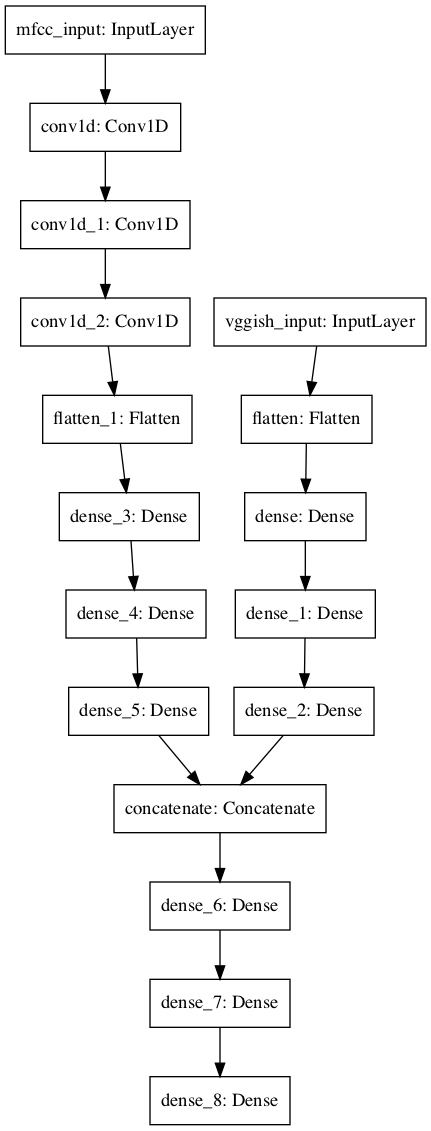

In [17]:
from tensorflow.keras.layers import Flatten, Dense, Input, Layer, GlobalAveragePooling1D, Conv1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import pydot
import graphviz


class GlobalVariancePooling1D(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        return K.var(x, axis=1)
    
def create_nn(x_vec=False):
    inputs = Input(shape=(10, 128), name='vggish_input')
    if x_vec:
        gap = GlobalAveragePooling1D()(inputs)
        gvp = GlobalVariancePooling1D()(inputs)
        net = concatenate([gap, gvp])
    else:
        net = Flatten()(inputs)
    net = Dense(500, activation='relu')(net)
    net = Dense(250, activation='relu')(net)
    net = Dense(100, activation='relu')(net)
    
    model = Model(inputs, net)
    
    return model


def create_mfcc_nn(x_vec=False):
    inputs = Input(shape=(20, 157), name='mfcc_input')
    conv1 = Conv1D(filters=64, kernel_size=2, input_shape=(20,157), activation='relu')(inputs)
    conv2 = Conv1D(filters=100, kernel_size=2, activation='relu')(conv1)
    conv3 = Conv1D(filters=200, kernel_size=2, activation='relu')(conv2)
    if x_vec:
        gap = GlobalAveragePooling1D()(conv3)
        gvp = GlobalVariancePooling1D()(conv3)
        net = concatenate([gap, gvp])
    else:
        net = Flatten()(conv3)
    net = Dense(500, activation='relu')(net)
    net = Dense(250, activation='relu')(net)
    net = Dense(100, activation='relu')(net)
    
    model = Model(inputs, net)
    
    
    return model

def create_multi_modal_nn(x_vec=False):
    m1 = create_nn(x_vec)
    m2 = create_mfcc_nn(x_vec)
    
    
    net = tf.keras.layers.Concatenate()([m1.output, m2.output])
    net = Dense(100, activation='relu')(net)
    net = Dense(50, activation='relu')(net)
    output = Dense(20, activation='linear')(net)
    
    model = Model(inputs=[m1.input, m2.input], outputs=[output])
    
    adam = Adam(1e-4)
    model.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae']) 
    
    return model



multi_modal_nn = create_multi_modal_nn()
multi_modal_nn.summary()

plot_model(multi_modal_nn)

## Training

In [18]:
# from tensorflow.data.Dataset import from_tensor_slices
batch_size = 16

# Convert to tf data
train_dataset = tf.data.Dataset.from_tensor_slices(({'vggish_input':x_train,'mfcc_input':mfccs_mean_std}, y_train)).cache().shuffle(100).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(({'vggish_input':x_test,'mfcc_input':test_mfccs_mean_std}, y_test)).cache().shuffle(100).batch(batch_size).repeat()
eval_dataset = tf.data.Dataset.from_tensor_slices(({'vggish_input':x_test,'mfcc_input':test_mfccs_mean_std}, y_test)).cache().batch(batch_size)

In [19]:
def get_residuals(model, eval_dataset):
    predictions = model.predict(eval_dataset)
    
    if isinstance(predictions, list):
        predictions = np.hstack(predictions)

    true_vals = test_meta_df.drop(['sample_key', 'index'], axis=1).to_numpy()
    residuals = predictions - true_vals
    residual_df = pd.DataFrame(residuals)
    residual_df.columns = [class_map_int[i] for i in range(20)]
    
    return residual_df

def plot_residuals(residual_df, log=False):
    # Long format 
    df = residual_df.melt(var_name='Instrument', value_name='Residual (%)')
    plt.figure(figsize=(16, 8))
    ax = sns.boxplot(x="Instrument", y="Residual (%)", data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    if log:
        ax.set(yscale="log")
    plt.show()

In [20]:
train_steps_per_epoch = len(x_train)//batch_size + int(len(x_train)%batch_size > 0)
val_steps_per_epoch = len(x_test)//batch_size + int(len(x_test)%batch_size > 0)

In [21]:
callbacks = [
    ModelCheckpoint(filepath='./models/multi.h5'),
    ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(patience=7, restore_best_weights=True)
]

multi_modal_nn.fit(train_dataset, validation_data=test_dataset,
                    epochs=1000, callbacks=callbacks,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1)

print('='*117)
print('Results:')

_, mse, mae = multi_modal_nn.evaluate(test_dataset, steps=val_steps_per_epoch, verbose=0)
print(f'MSE: {mse:.2f}\tMAE: {mae:.3f}')

Train for 933 steps, validate for 318 steps
Epoch 1/1000
933/933 [==============================] - 26s 28ms/step - loss: 16.5226 - mse: 16.5369 - mae: 0.8934 - val_loss: 0.0473 - val_mse: 0.0473 - val_mae: 0.0583
Epoch 2/1000
933/933 [==============================] - 25s 27ms/step - loss: 0.0415 - mse: 0.0416 - mae: 0.0501 - val_loss: 0.0412 - val_mse: 0.0412 - val_mae: 0.0498
Epoch 3/1000
933/933 [==============================] - 26s 28ms/step - loss: 0.0398 - mse: 0.0399 - mae: 0.0497 - val_loss: 0.0400 - val_mse: 0.0400 - val_mae: 0.0519
Epoch 4/1000
933/933 [==============================] - 27s 29ms/step - loss: 0.0391 - mse: 0.0392 - mae: 0.0536 - val_loss: 0.0395 - val_mse: 0.0395 - val_mae: 0.0572
Epoch 5/1000
933/933 [==============================] - 26s 28ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.0599 - val_loss: 0.0396 - val_mse: 0.0396 - val_mae: 0.0646
Epoch 6/1000
933/933 [==============================] - 27s 29ms/step - loss: 0.0384 - mse: 0.0384 - mae: 0.0664 -

After creating the model above, we want to explore which classes we struggled with the most.  We want to do this so that we can have a better understanding of which instruments are difficult to regress and then possible increase the depth of the network for specific instruments.  Below, you can see a residuals plot for each instrument using the trained model and the test data.  Please note that the variable we are trying to regress `relevance_score` is measured in a percentage scale from 0 to 1.  This means that decimal values of say .2 are quite large because we would be 20% away from the true score.  As a reminder, the residual is calculated as the following:

$$Residual = relevance\_score_{true} - relevance\_score_{predicted}$$

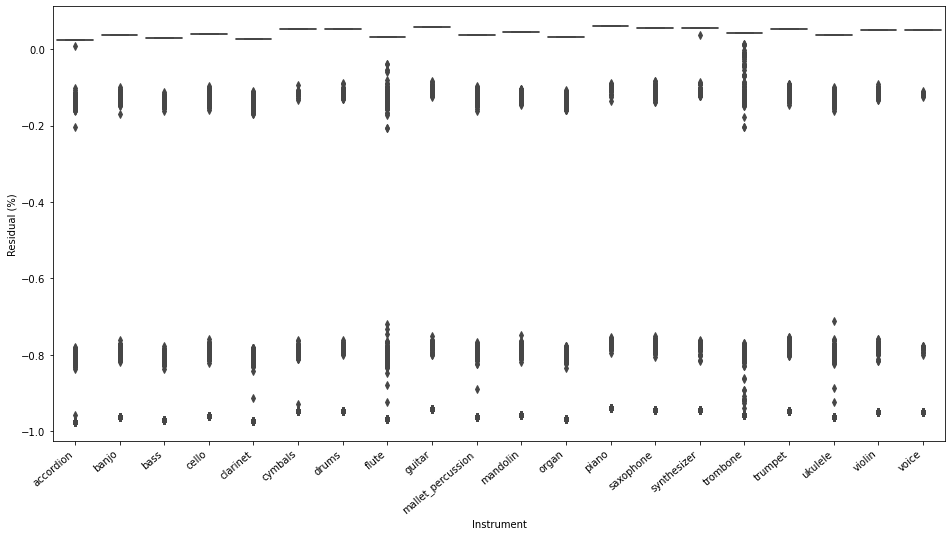

In [22]:
residual_df = get_residuals(multi_modal_nn, eval_dataset)
plot_residuals(residual_df)

In [23]:
residual_df.describe()

,accordion,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,mallet_percussion,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
count,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000
mean,0.001108,0.009776,0.002257,-0.002982,-0.001819,-0.004354,-0.001730,-0.002971,0.002417,-0.004392,0.005387,0.006750,0.004534,-0.005300,0.002953,-0.004251,-0.008902,0.000597,-0.025773,0.006910
std,0.136596,0.151785,0.147547,0.192863,0.144242,0.228690,0.221485,0.165389,0.226387,0.187812,0.172768,0.140533,0.225996,0.226462,0.217142,0.193175,0.226961,0.170877,0.258880,0.202956
min,-0.974679,-0.961654,-0.970813,-0.959191,-0.972316,-0.946873,-0.947548,-0.967278,-0.941497,-0.963343,-0.956257,-0.968402,-0.939888,-0.945645,-0.944864,-0.957919,-0.946236,-0.962627,-0.948918,-0.949190
25%,0.025321,0.038346,0.029187,0.040809,0.027684,0.053127,0.052452,0.032722,0.058503,0.036657,0.043743,0.031598,0.060112,0.054355,0.055136,0.042081,0.053764,0.037373,0.051082,0.050810
50%,0.025321,0.038346,0.029187,0.040809,0.027684,0.053127,0.052452,0.032722,0.058503,0.036657,0.043743,0.031598,0.060112,0.054355,0.055136,0.042081,0.053764,0.037373,0.051082,0.050810
75%,0.025321,0.038346,0.029187,0.040809,0.027684,0.053127,0.052452,0.032722,0.058503,0.036657,0.043743,0.031598,0.060112,0.054355,0.055136,0.042081,0.053764,0.037373,0.051082,0.050810
max,0.025321,0.038346,0.029187,0.040809,0.027684,0.053127,0.052452,0.032722,0.058503,0.036657,0.043743,0.031598,0.060112,0.054355,0.055136,0.042081,0.053764,0.037373,0.051082,0.050810


In [24]:
residual_df.melt().describe()

,value
count,101700.000000
mean,-0.000989
std,0.195320
min,-0.974679
25%,0.031598
50%,0.042081
75%,0.053127
max,0.060112


We can see that our model preforms almost equally for most instruments.  Most of the boxplots are squashed down right around a residual of 0 (which is what we want), but we seem to have a lot of outliers.  Identifying instruments that perform worse than others and then making deeper branches for them doesn't seem to be the best method here.  We still want to investigate something like this though because maybe grouping the instruments will help us perform a little better.  For example, an organ and a piano likely have very similar activations.  The idea we have here is that the network may have to generalize too much into a shared latent represenation with all instruments even though some instruments are very different than others.  If we instead do this branching architecture, the top, shared latent representation is more of a feature extractor and the later layers then can be specific for each instrument group. **add more**

To better group our instruments, we have come up with the following groups:

* Group 1
    * Banjo
    * Bass 
    * Cello
    * Guitar
    * Mandolin
    * Ukulele
    * Violin
    
* Group 2
    * Clarinet
    * Flute
    * Saxophone
    
* Group 3
    * Accordian 
    * Organ
    * Piano
    * Synthesizer
    
* Group 4
    * Cymbals
    * Drums
    * Mallet percussion
    
* Group 5
    * Trombone
    * Trumpet
    
* Group 6
    * Voice
    
   
We came up with these groups by just the type of instruments that we thought were similar.  We are not experts in music, so this may not be the best grouping, but we think it is reasonable.  **add more on possbile architectures**
    

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc_input (InputLayer)         [(None, 20, 157)]    0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 19, 64)       20160       mfcc_input[0][0]                 
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 18, 100)      12900       conv1d_3[0][0]                   
__________________________________________________________________________________________________
vggish_input (InputLayer)       [(None, 10, 128)]    0                                            
____________________________________________________________________________________________

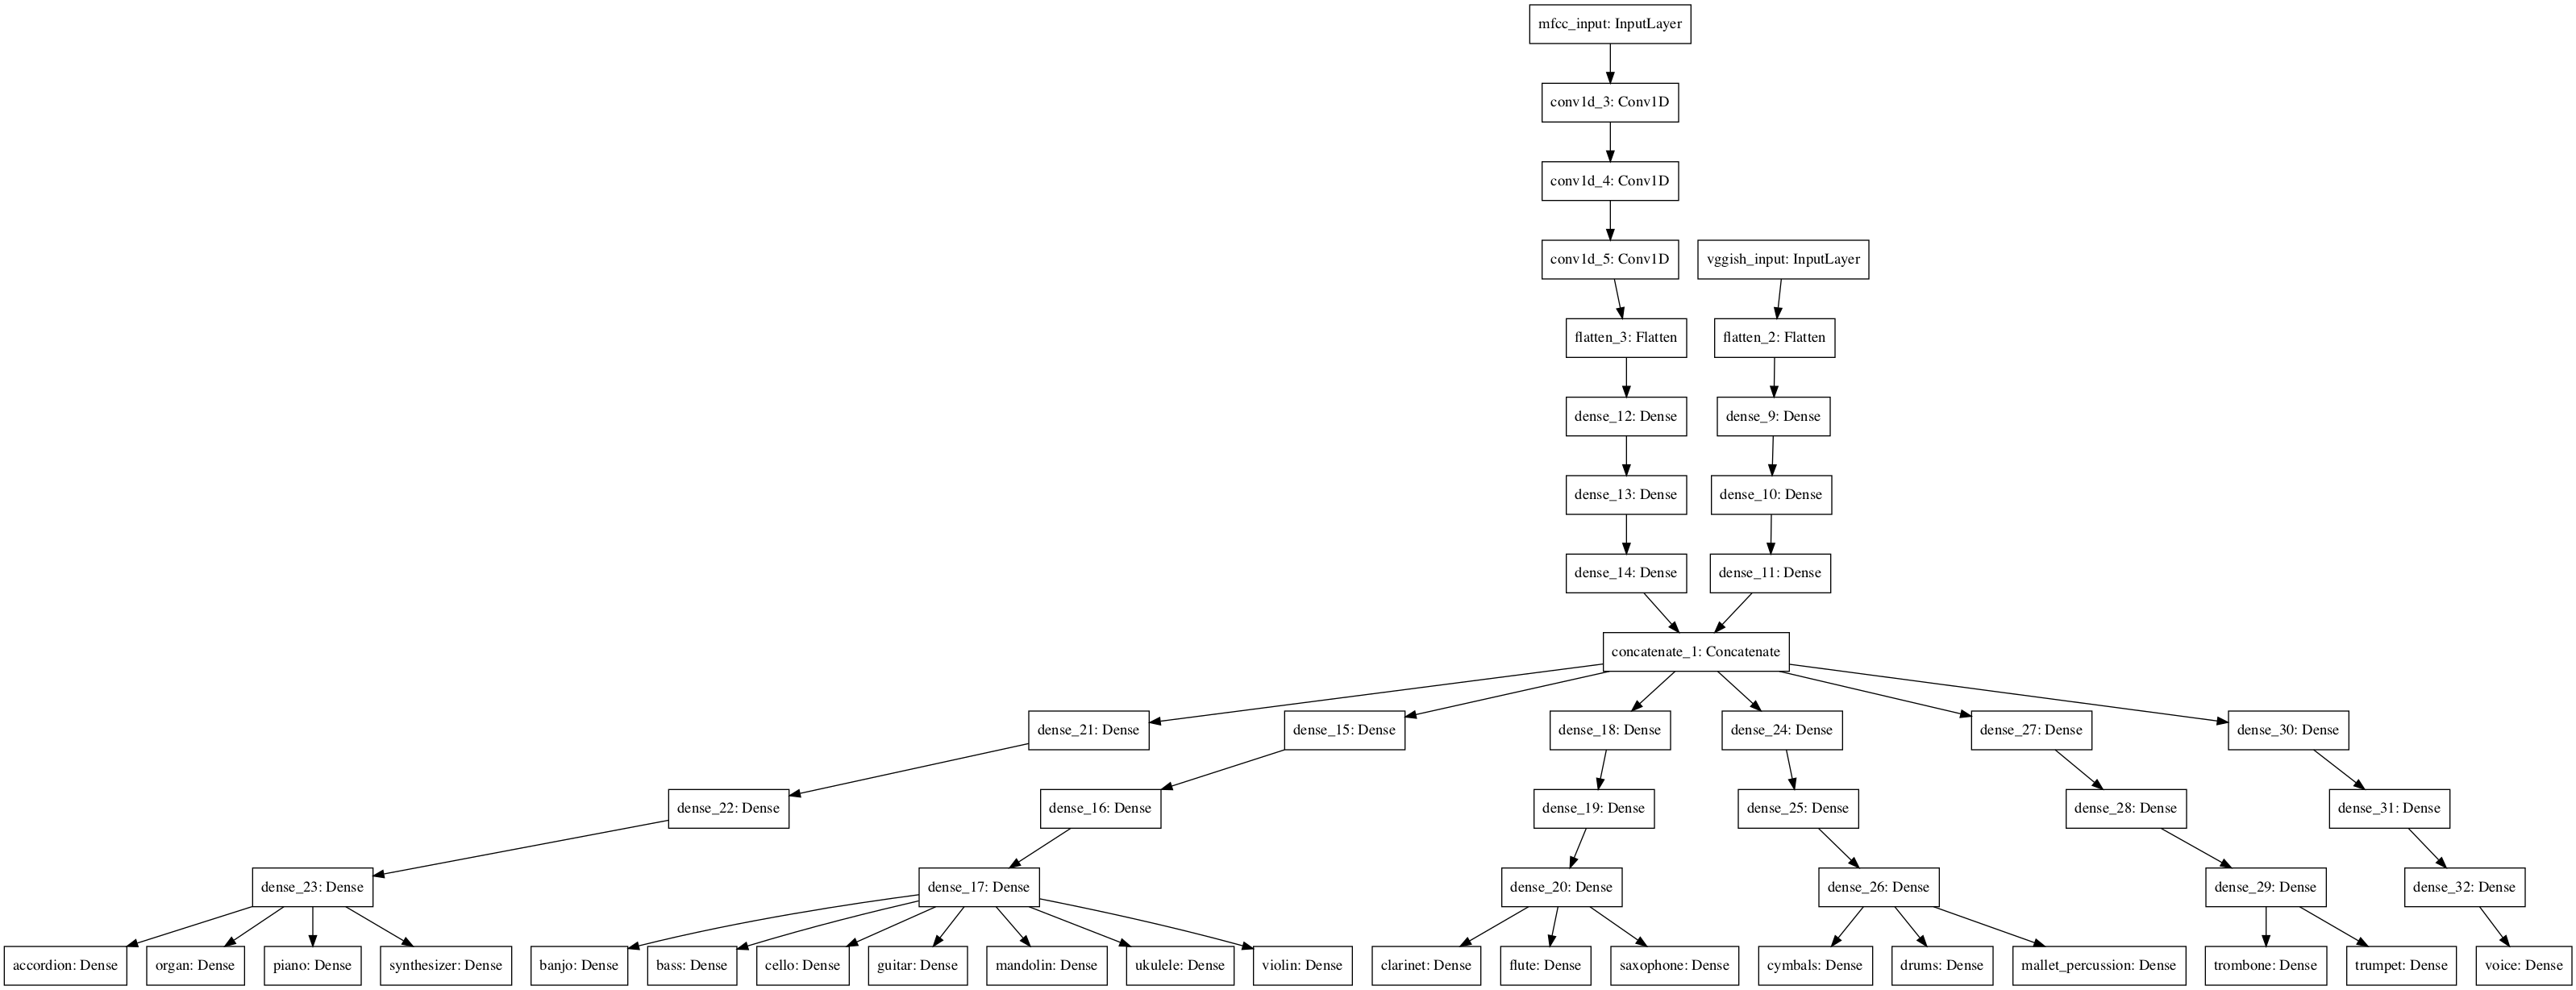

In [25]:
def create_branched_nn(x_vec=False):
    m1 = create_nn(x_vec)
    m2 = create_mfcc_nn(x_vec)
    
    
    net = tf.keras.layers.Concatenate()([m1.output, m2.output])
    
    # Group 1
    g1 = Dense(150, activation='relu')(net)
    g1 = Dense(120, activation='relu')(g1)
    g1 = Dense(100, activation='relu')(g1)
    banjo = Dense(1, activation='linear', name='banjo')(g1)
    bass = Dense(1, activation='linear', name='bass')(g1)
    cello = Dense(1, activation='linear', name='cello')(g1)
    guitar = Dense(1, activation='linear', name='guitar')(g1)
    mandolin = Dense(1, activation='linear', name='mandolin')(g1)
    ukulele = Dense(1, activation='linear', name='ukulele')(g1)
    violin = Dense(1, activation='linear', name='violin')(g1)

    # Group 2
    g2 = Dense(150, activation='relu')(net)
    g2 = Dense(120, activation='relu')(g2)
    g2 = Dense(100, activation='relu')(g2)
    clarinet = Dense(1, activation='linear', name='clarinet')(g2)
    flute = Dense(1, activation='linear', name='flute')(g2)
    saxophone = Dense(1, activation='linear', name='saxophone')(g2)
    
    # Group 3
    g3 = Dense(150, activation='relu')(net)
    g3 = Dense(120, activation='relu')(g3)
    g3 = Dense(100, activation='relu')(g3)
    accordion = Dense(1, activation='linear', name='accordion')(g3)
    organ = Dense(1, activation='linear', name='organ')(g3)
    piano = Dense(1, activation='linear', name='piano')(g3)
    synthesizer = Dense(1, activation='linear', name='synthesizer')(g3)
    
    # Group 4
    g4 = Dense(150, activation='relu')(net)
    g4 = Dense(120, activation='relu')(g4)
    g4 = Dense(100, activation='relu')(g4)
    cymbals = Dense(1, activation='linear', name='cymbals')(g4)
    drums = Dense(1, activation='linear', name='drums')(g4)
    mallet_percussion = Dense(1, activation='linear', name='mallet_percussion')(g4)
    
    # Group 5
    g5 = Dense(150, activation='relu')(net)
    g5 = Dense(120, activation='relu')(g5)
    g5 = Dense(100, activation='relu')(g5)
    trombone = Dense(1, activation='linear', name='trombone')(g5)
    trumpet = Dense(1, activation='linear', name='trumpet')(g5)
    
    # Group 6
    g6 = Dense(150, activation='relu')(net)
    g6 = Dense(120, activation='relu')(g6)
    g6 = Dense(100, activation='relu')(g6)
    voice = Dense(1, activation='linear', name='voice')(g6)
    
    model = Model(inputs=[m1.input, m2.input], outputs=[accordion, banjo, bass, cello, 
                                                        clarinet, cymbals, drums, flute, 
                                                        guitar, mallet_percussion, mandolin, organ, 
                                                        piano, saxophone, synthesizer, trombone, 
                                                        trumpet, ukulele, violin, voice])
    
    adam = Adam(1e-4)
    model.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae']) 
    
    return model

branched_nn = create_branched_nn()
branched_nn.summary()

plot_model(branched_nn)


In [26]:
train_dict = {key: y_train[:, i] for key, i in zip(class_map.keys(), range(20))}
test_dict = {key: y_test[:, i] for key, i in zip(class_map.keys(), range(20))}

In [27]:
# Convert to tf data, slightly different label input shape for the branched network 
branched_train_dataset = tf.data.Dataset.from_tensor_slices((
    {'vggish_input':x_train,'mfcc_input':mfccs_mean_std},
    train_dict)).cache().shuffle(100).batch(batch_size).repeat()
branched_test_dataset = tf.data.Dataset.from_tensor_slices((
    {'vggish_input':x_test,'mfcc_input':test_mfccs_mean_std},
    test_dict)).cache().shuffle(100).batch(batch_size).repeat()
branched_eval_dataset = tf.data.Dataset.from_tensor_slices((
    {'vggish_input':x_test,'mfcc_input':test_mfccs_mean_std},
    test_dict)).cache().batch(batch_size)


callbacks = [
    ModelCheckpoint(filepath='./models/branched.h5'),
    ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(patience=7, restore_best_weights=True)
]

branched_nn.fit(branched_train_dataset, validation_data=branched_test_dataset,
                    epochs=1000, callbacks=callbacks,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1)

print('='*117)
print('Results:')

results = branched_nn.evaluate(branched_test_dataset, steps=val_steps_per_epoch, verbose=0)
loss = results[0]
mse_results = {key+'_mse': res for key, res in zip(class_map.keys(), results[21:41])}
mae_results = {key+'_mae': res for key, res in zip(class_map.keys(), results[41:61])}
print(f'Total Loss: {loss}')
print('='*117)
print(f'MSE:\n{mse_results}')
print('='*117)
print(f'MAE:\n{mae_results}')

Train for 933 steps, validate for 318 steps
Epoch 1/1000
933/933 [==============================] - 48s 51ms/step - loss: 100.0767 - accordion_loss: 3.6302 - banjo_loss: 6.4306 - bass_loss: 3.9487 - cello_loss: 9.8896 - clarinet_loss: 3.5959 - cymbals_loss: 6.8066 - drums_loss: 4.3050 - flute_loss: 2.9047 - guitar_loss: 4.6406 - mallet_percussion_loss: 4.5496 - mandolin_loss: 7.4137 - organ_loss: 2.2938 - piano_loss: 4.5929 - saxophone_loss: 3.9310 - synthesizer_loss: 5.6306 - trombone_loss: 8.2136 - trumpet_loss: 3.6152 - ukulele_loss: 5.0877 - violin_loss: 4.9942 - voice_loss: 3.6025 - accordion_mse: 3.6334 - accordion_mae: 0.9601 - banjo_mse: 6.4361 - banjo_mae: 1.2437 - bass_mse: 3.9521 - bass_mae: 1.0109 - cello_mse: 9.8982 - cello_mae: 1.5609 - clarinet_mse: 3.5989 - clarinet_mae: 0.9593 - cymbals_mse: 6.8125 - cymbals_mae: 1.1105 - drums_mse: 4.3084 - drums_mae: 1.0306 - flute_mse: 2.9071 - flute_mae: 0.8959 - guitar_mse: 4.6442 - guitar_mae: 1.0854 - mallet_percussion_mse: 4.55

Epoch 4/1000
933/933 [==============================] - 35s 38ms/step - loss: 0.9952 - accordion_loss: 0.0318 - banjo_loss: 0.0487 - bass_loss: 0.0340 - cello_loss: 0.0525 - clarinet_loss: 0.0316 - cymbals_loss: 0.0640 - drums_loss: 0.0573 - flute_loss: 0.0370 - guitar_loss: 0.0622 - mallet_percussion_loss: 0.0457 - mandolin_loss: 0.0431 - organ_loss: 0.0294 - piano_loss: 0.0535 - saxophone_loss: 0.0595 - synthesizer_loss: 0.0568 - trombone_loss: 0.0501 - trumpet_loss: 0.0577 - ukulele_loss: 0.0459 - violin_loss: 0.0609 - voice_loss: 0.0737 - accordion_mse: 0.0319 - accordion_mae: 0.1092 - banjo_mse: 0.0487 - banjo_mae: 0.1493 - bass_mse: 0.0340 - bass_mae: 0.1137 - cello_mse: 0.0525 - cello_mae: 0.1586 - clarinet_mse: 0.0313 - clarinet_mae: 0.1066 - cymbals_mse: 0.0640 - cymbals_mae: 0.1677 - drums_mse: 0.0574 - drums_mae: 0.1584 - flute_mse: 0.0370 - flute_mae: 0.1211 - guitar_mse: 0.0622 - guitar_mae: 0.1690 - mallet_percussion_mse: 0.0457 - mallet_percussion_mae: 0.1385 - mandolin_

Epoch 7/1000
933/933 [==============================] - 36s 39ms/step - loss: 0.8200 - accordion_loss: 0.0298 - banjo_loss: 0.0345 - bass_loss: 0.0284 - cello_loss: 0.0417 - clarinet_loss: 0.0289 - cymbals_loss: 0.0525 - drums_loss: 0.0489 - flute_loss: 0.0326 - guitar_loss: 0.0474 - mallet_percussion_loss: 0.0411 - mandolin_loss: 0.0340 - organ_loss: 0.0257 - piano_loss: 0.0368 - saxophone_loss: 0.0528 - synthesizer_loss: 0.0485 - trombone_loss: 0.0502 - trumpet_loss: 0.0559 - ukulele_loss: 0.0299 - violin_loss: 0.0430 - voice_loss: 0.0573 - accordion_mse: 0.0298 - accordion_mae: 0.1035 - banjo_mse: 0.0345 - banjo_mae: 0.1164 - bass_mse: 0.0285 - bass_mae: 0.1000 - cello_mse: 0.0415 - cello_mae: 0.1321 - clarinet_mse: 0.0289 - clarinet_mae: 0.1018 - cymbals_mse: 0.0525 - cymbals_mae: 0.1490 - drums_mse: 0.0489 - drums_mae: 0.1456 - flute_mse: 0.0326 - flute_mae: 0.1110 - guitar_mse: 0.0474 - guitar_mae: 0.1347 - mallet_percussion_mse: 0.0412 - mallet_percussion_mae: 0.1286 - mandolin_

Epoch 10/1000
933/933 [==============================] - 35s 37ms/step - loss: 0.6692 - accordion_loss: 0.0250 - banjo_loss: 0.0291 - bass_loss: 0.0241 - cello_loss: 0.0350 - clarinet_loss: 0.0259 - cymbals_loss: 0.0432 - drums_loss: 0.0387 - flute_loss: 0.0276 - guitar_loss: 0.0419 - mallet_percussion_loss: 0.0337 - mandolin_loss: 0.0291 - organ_loss: 0.0223 - piano_loss: 0.0238 - saxophone_loss: 0.0462 - synthesizer_loss: 0.0399 - trombone_loss: 0.0380 - trumpet_loss: 0.0433 - ukulele_loss: 0.0266 - violin_loss: 0.0370 - voice_loss: 0.0390 - accordion_mse: 0.0250 - accordion_mae: 0.0861 - banjo_mse: 0.0291 - banjo_mae: 0.1049 - bass_mse: 0.0241 - bass_mae: 0.0859 - cello_mse: 0.0350 - cello_mae: 0.1177 - clarinet_mse: 0.0259 - clarinet_mae: 0.0936 - cymbals_mse: 0.0432 - cymbals_mae: 0.1354 - drums_mse: 0.0388 - drums_mae: 0.1221 - flute_mse: 0.0276 - flute_mae: 0.0957 - guitar_mse: 0.0419 - guitar_mae: 0.1301 - mallet_percussion_mse: 0.0337 - mallet_percussion_mae: 0.1106 - mandolin

933/933 [==============================] - 36s 38ms/step - loss: 0.5720 - accordion_loss: 0.0235 - banjo_loss: 0.0260 - bass_loss: 0.0224 - cello_loss: 0.0321 - clarinet_loss: 0.0222 - cymbals_loss: 0.0360 - drums_loss: 0.0336 - flute_loss: 0.0256 - guitar_loss: 0.0359 - mallet_percussion_loss: 0.0287 - mandolin_loss: 0.0251 - organ_loss: 0.0210 - piano_loss: 0.0194 - saxophone_loss: 0.0405 - synthesizer_loss: 0.0305 - trombone_loss: 0.0315 - trumpet_loss: 0.0348 - ukulele_loss: 0.0242 - violin_loss: 0.0320 - voice_loss: 0.0269 - accordion_mse: 0.0235 - accordion_mae: 0.0818 - banjo_mse: 0.0260 - banjo_mae: 0.0989 - bass_mse: 0.0224 - bass_mae: 0.0806 - cello_mse: 0.0321 - cello_mae: 0.1131 - clarinet_mse: 0.0222 - clarinet_mae: 0.0831 - cymbals_mse: 0.0360 - cymbals_mae: 0.1197 - drums_mse: 0.0337 - drums_mae: 0.1105 - flute_mse: 0.0255 - flute_mae: 0.0921 - guitar_mse: 0.0359 - guitar_mae: 0.1220 - mallet_percussion_mse: 0.0287 - mallet_percussion_mae: 0.1027 - mandolin_mse: 0.0250 -

Epoch 15/1000
933/933 [==============================] - 36s 38ms/step - loss: 0.4335 - accordion_loss: 0.0202 - banjo_loss: 0.0218 - bass_loss: 0.0195 - cello_loss: 0.0229 - clarinet_loss: 0.0188 - cymbals_loss: 0.0277 - drums_loss: 0.0266 - flute_loss: 0.0207 - guitar_loss: 0.0238 - mallet_percussion_loss: 0.0194 - mandolin_loss: 0.0208 - organ_loss: 0.0181 - piano_loss: 0.0141 - saxophone_loss: 0.0275 - synthesizer_loss: 0.0196 - trombone_loss: 0.0246 - trumpet_loss: 0.0265 - ukulele_loss: 0.0200 - violin_loss: 0.0223 - voice_loss: 0.0185 - accordion_mse: 0.0201 - accordion_mae: 0.0741 - banjo_mse: 0.0218 - banjo_mae: 0.0896 - bass_mse: 0.0195 - bass_mae: 0.0722 - cello_mse: 0.0229 - cello_mae: 0.0959 - clarinet_mse: 0.0188 - clarinet_mae: 0.0750 - cymbals_mse: 0.0277 - cymbals_mae: 0.1033 - drums_mse: 0.0266 - drums_mae: 0.0970 - flute_mse: 0.0207 - flute_mae: 0.0845 - guitar_mse: 0.0239 - guitar_mae: 0.0863 - mallet_percussion_mse: 0.0194 - mallet_percussion_mae: 0.0862 - mandolin

Epoch 18/1000
933/933 [==============================] - 35s 37ms/step - loss: 0.3107 - accordion_loss: 0.0164 - banjo_loss: 0.0182 - bass_loss: 0.0156 - cello_loss: 0.0160 - clarinet_loss: 0.0150 - cymbals_loss: 0.0196 - drums_loss: 0.0192 - flute_loss: 0.0108 - guitar_loss: 0.0177 - mallet_percussion_loss: 0.0130 - mandolin_loss: 0.0162 - organ_loss: 0.0151 - piano_loss: 0.0088 - saxophone_loss: 0.0194 - synthesizer_loss: 0.0138 - trombone_loss: 0.0156 - trumpet_loss: 0.0160 - ukulele_loss: 0.0176 - violin_loss: 0.0142 - voice_loss: 0.0124 - accordion_mse: 0.0164 - accordion_mae: 0.0708 - banjo_mse: 0.0182 - banjo_mae: 0.0825 - bass_mse: 0.0156 - bass_mae: 0.0670 - cello_mse: 0.0160 - cello_mae: 0.0844 - clarinet_mse: 0.0151 - clarinet_mae: 0.0680 - cymbals_mse: 0.0197 - cymbals_mae: 0.0872 - drums_mse: 0.0192 - drums_mae: 0.0814 - flute_mse: 0.0109 - flute_mae: 0.0658 - guitar_mse: 0.0177 - guitar_mae: 0.0740 - mallet_percussion_mse: 0.0130 - mallet_percussion_mae: 0.0749 - mandolin

Epoch 21/1000
933/933 [==============================] - 37s 39ms/step - loss: 0.1928 - accordion_loss: 0.0116 - banjo_loss: 0.0137 - bass_loss: 0.0098 - cello_loss: 0.0085 - clarinet_loss: 0.0095 - cymbals_loss: 0.0108 - drums_loss: 0.0117 - flute_loss: 0.0041 - guitar_loss: 0.0134 - mallet_percussion_loss: 0.0071 - mandolin_loss: 0.0105 - organ_loss: 0.0125 - piano_loss: 0.0053 - saxophone_loss: 0.0109 - synthesizer_loss: 0.0086 - trombone_loss: 0.0094 - trumpet_loss: 0.0090 - ukulele_loss: 0.0124 - violin_loss: 0.0072 - voice_loss: 0.0069 - accordion_mse: 0.0116 - accordion_mae: 0.0621 - banjo_mse: 0.0137 - banjo_mae: 0.0756 - bass_mse: 0.0098 - bass_mae: 0.0556 - cello_mse: 0.0085 - cello_mae: 0.0647 - clarinet_mse: 0.0095 - clarinet_mae: 0.0569 - cymbals_mse: 0.0108 - cymbals_mae: 0.0663 - drums_mse: 0.0117 - drums_mae: 0.0631 - flute_mse: 0.0041 - flute_mae: 0.0422 - guitar_mse: 0.0135 - guitar_mae: 0.0660 - mallet_percussion_mse: 0.0071 - mallet_percussion_mae: 0.0586 - mandolin

Epoch 24/1000
932/933 [============================>.] - ETA: 0s - loss: 0.1056 - accordion_loss: 0.0060 - banjo_loss: 0.0078 - bass_loss: 0.0040 - cello_loss: 0.0036 - clarinet_loss: 0.0043 - cymbals_loss: 0.0055 - drums_loss: 0.0059 - flute_loss: 0.0025 - guitar_loss: 0.0096 - mallet_percussion_loss: 0.0031 - mandolin_loss: 0.0070 - organ_loss: 0.0080 - piano_loss: 0.0028 - saxophone_loss: 0.0046 - synthesizer_loss: 0.0043 - trombone_loss: 0.0060 - trumpet_loss: 0.0060 - ukulele_loss: 0.0077 - violin_loss: 0.0039 - voice_loss: 0.0030 - accordion_mse: 0.0060 - accordion_mae: 0.0470 - banjo_mse: 0.0078 - banjo_mae: 0.0605 - bass_mse: 0.0040 - bass_mae: 0.0390 - cello_mse: 0.0036 - cello_mae: 0.0418 - clarinet_mse: 0.0043 - clarinet_mae: 0.0398 - cymbals_mse: 0.0055 - cymbals_mae: 0.0487 - drums_mse: 0.0059 - drums_mae: 0.0453 - flute_mse: 0.0025 - flute_mae: 0.0308 - guitar_mse: 0.0096 - guitar_mae: 0.0588 - mallet_percussion_mse: 0.0031 - mallet_percussion_mae: 0.0394 - mandolin_mse: 

933/933 [==============================] - 34s 37ms/step - loss: 0.0689 - accordion_loss: 0.0036 - banjo_loss: 0.0054 - bass_loss: 0.0026 - cello_loss: 0.0024 - clarinet_loss: 0.0028 - cymbals_loss: 0.0034 - drums_loss: 0.0030 - flute_loss: 0.0017 - guitar_loss: 0.0065 - mallet_percussion_loss: 0.0020 - mandolin_loss: 0.0052 - organ_loss: 0.0056 - piano_loss: 0.0016 - saxophone_loss: 0.0024 - synthesizer_loss: 0.0027 - trombone_loss: 0.0038 - trumpet_loss: 0.0038 - ukulele_loss: 0.0058 - violin_loss: 0.0030 - voice_loss: 0.0016 - accordion_mse: 0.0036 - accordion_mae: 0.0360 - banjo_mse: 0.0054 - banjo_mae: 0.0502 - bass_mse: 0.0027 - bass_mae: 0.0308 - cello_mse: 0.0024 - cello_mae: 0.0338 - clarinet_mse: 0.0028 - clarinet_mae: 0.0313 - cymbals_mse: 0.0034 - cymbals_mae: 0.0364 - drums_mse: 0.0030 - drums_mae: 0.0310 - flute_mse: 0.0017 - flute_mae: 0.0234 - guitar_mse: 0.0065 - guitar_mae: 0.0492 - mallet_percussion_mse: 0.0020 - mallet_percussion_mae: 0.0306 - mandolin_mse: 0.0052 -

Epoch 29/1000
933/933 [==============================] - 36s 38ms/step - loss: 0.0536 - accordion_loss: 0.0028 - banjo_loss: 0.0044 - bass_loss: 0.0021 - cello_loss: 0.0016 - clarinet_loss: 0.0022 - cymbals_loss: 0.0025 - drums_loss: 0.0021 - flute_loss: 0.0012 - guitar_loss: 0.0056 - mallet_percussion_loss: 0.0014 - mandolin_loss: 0.0044 - organ_loss: 0.0046 - piano_loss: 0.0013 - saxophone_loss: 0.0015 - synthesizer_loss: 0.0020 - trombone_loss: 0.0030 - trumpet_loss: 0.0029 - ukulele_loss: 0.0048 - violin_loss: 0.0020 - voice_loss: 0.0012 - accordion_mse: 0.0028 - accordion_mae: 0.0325 - banjo_mse: 0.0044 - banjo_mae: 0.0462 - bass_mse: 0.0021 - bass_mae: 0.0280 - cello_mse: 0.0016 - cello_mae: 0.0287 - clarinet_mse: 0.0022 - clarinet_mae: 0.0282 - cymbals_mse: 0.0025 - cymbals_mae: 0.0321 - drums_mse: 0.0021 - drums_mae: 0.0269 - flute_mse: 0.0012 - flute_mae: 0.0200 - guitar_mse: 0.0056 - guitar_mae: 0.0469 - mallet_percussion_mse: 0.0014 - mallet_percussion_mae: 0.0262 - mandolin

933/933 [==============================] - 38s 40ms/step - loss: 0.0515 - accordion_loss: 0.0025 - banjo_loss: 0.0043 - bass_loss: 0.0020 - cello_loss: 0.0016 - clarinet_loss: 0.0021 - cymbals_loss: 0.0024 - drums_loss: 0.0019 - flute_loss: 0.0011 - guitar_loss: 0.0051 - mallet_percussion_loss: 0.0014 - mandolin_loss: 0.0043 - organ_loss: 0.0044 - piano_loss: 0.0012 - saxophone_loss: 0.0015 - synthesizer_loss: 0.0019 - trombone_loss: 0.0031 - trumpet_loss: 0.0028 - ukulele_loss: 0.0046 - violin_loss: 0.0021 - voice_loss: 0.0012 - accordion_mse: 0.0025 - accordion_mae: 0.0302 - banjo_mse: 0.0043 - banjo_mae: 0.0456 - bass_mse: 0.0020 - bass_mae: 0.0273 - cello_mse: 0.0016 - cello_mae: 0.0286 - clarinet_mse: 0.0021 - clarinet_mae: 0.0276 - cymbals_mse: 0.0024 - cymbals_mae: 0.0309 - drums_mse: 0.0019 - drums_mae: 0.0249 - flute_mse: 0.0011 - flute_mae: 0.0190 - guitar_mse: 0.0051 - guitar_mae: 0.0445 - mallet_percussion_mse: 0.0014 - mallet_percussion_mae: 0.0256 - mandolin_mse: 0.0043 -

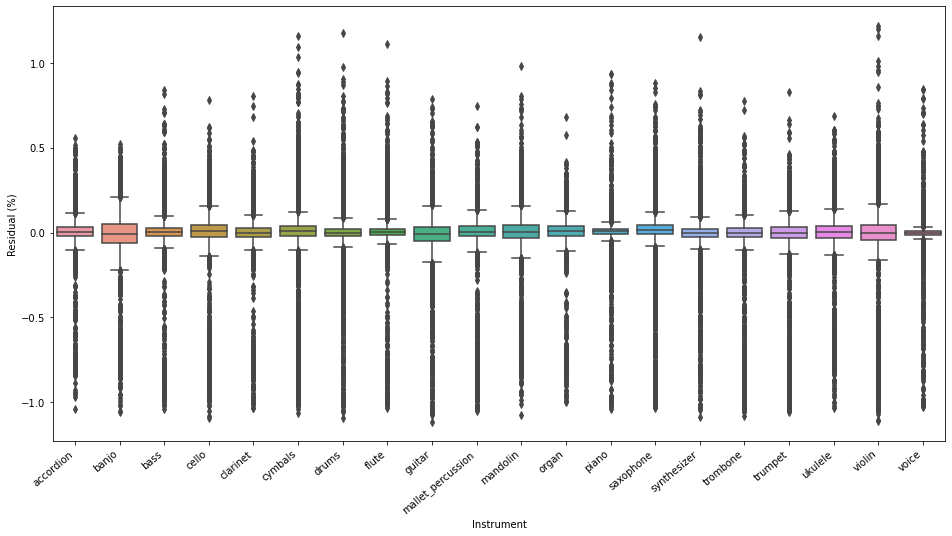

In [28]:
branched_df = get_residuals(branched_nn, branched_eval_dataset)
plot_residuals(branched_df)

In [29]:
branched_df.describe()

,accordion,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,mallet_percussion,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
count,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000
mean,0.002454,-0.010625,-0.008773,-0.011187,-0.013942,0.001234,-0.007849,-0.008355,-0.017171,-0.011440,-0.004074,-0.000097,-0.004178,0.009059,-0.009921,-0.027995,-0.036031,-0.007580,-0.028531,-0.014975
std,0.119175,0.144261,0.146254,0.178203,0.144752,0.179669,0.152852,0.168350,0.149081,0.164059,0.151864,0.125440,0.120376,0.171980,0.143634,0.166448,0.195161,0.146768,0.230940,0.126780
min,-1.037058,-1.054185,-1.042048,-1.094679,-1.033924,-1.064732,-1.094015,-1.034523,-1.113524,-1.048324,-1.077331,-0.996475,-1.042243,-1.034376,-1.086319,-1.080354,-1.059455,-1.031649,-1.110993,-1.028693
25%,-0.021784,-0.059002,-0.022318,-0.027979,-0.026806,-0.017700,-0.020796,-0.013278,-0.048721,-0.022702,-0.033186,-0.018466,-0.007321,-0.005506,-0.024879,-0.026314,-0.031480,-0.030004,-0.041181,-0.012061
50%,0.002834,-0.008631,0.001170,0.007371,-0.002966,0.009020,-0.000175,0.004383,-0.008250,0.006374,0.005278,0.009450,0.006890,0.017544,-0.002779,0.000286,-0.000095,0.002418,-0.000940,-0.002810
75%,0.033380,0.048796,0.025324,0.046330,0.024705,0.038781,0.022956,0.023500,0.035564,0.039782,0.043762,0.040709,0.021030,0.045313,0.022238,0.025327,0.031487,0.037690,0.044262,0.007008
max,0.558279,0.521819,0.837663,0.783713,0.803890,1.155926,1.173696,1.109277,0.789241,0.746889,0.983250,0.679780,0.936844,0.878498,1.152975,0.774455,0.828351,0.686574,1.215701,0.847126


In [30]:
branched_df.melt().describe()

,value
count,101700.000000
mean,-0.010499
std,0.158847
min,-1.113524
25%,-0.023917
50%,0.002471
75%,0.031222
max,1.215701


To our surprise, the branching network did not outperform the orginal network in terms of the overall mean residual value (-.00099 vs. -.01).  We thought this was very surprising since more layers could mean better distillation of information; however, a deeper network could have just added too much complexity and/or gradient issues.  For the most part, the mean residual for the instruments was better for the initial model than the branching model, but the branching model did better on some instruments.  Since we did not weigh the importance of any instruments in particular, the empirical results are in favor of the initial model in terms of mean residuals.  

With all that being said, the branched network significantly outperformed initial model in terms of the standard deviations of residuals for instruments.  The residual standard deviation for each instrument was smaller for the branched network meaning that the predictions are not as all over the place.  If the company we were designing this model for cared more about **consistently** getting good predictions vs. getting better predictions but sometimes including many more outliers, then the branched model would be preferred.

## F-Test

In [33]:
%config Completer.use_jedi = False



In [34]:
import scipy
from pprint import pprint

f = scipy.stats.f_oneway(residual_df, branched_df)
f_stat_by_class = f[0]
p_vals = f[1]
pprint(f_stat_by_class)
pprint(p_vals)
        

array([ 0.28049918, 48.26330613, 14.33397334,  4.96470963, 17.89664799,
        1.87720876,  2.62904855,  2.64707506, 26.55305153,  4.06130313,
        8.60216103,  6.71819901,  5.88699824, 12.96631008, 12.43324764,
       44.08905627, 41.76912629,  6.70072865,  0.32127501, 42.53183804])
array([5.96385789e-01, 3.95482377e-12, 1.53957794e-04, 2.58914433e-02,
       2.35276129e-05, 1.70681980e-01, 1.04955578e-01, 1.03771604e-01,
       2.61210564e-07, 4.39028913e-02, 3.36513609e-03, 9.55704332e-03,
       1.52703516e-02, 3.18657272e-04, 4.23615167e-04, 3.29791036e-11,
       1.07419553e-10, 9.65107080e-03, 5.70854926e-01, 7.28451526e-11])


In [36]:
sig_95 = p_vals < 0.05
sig_90 = p_vals < 0.1

print("Classes improved with 95% confidence: ", len(branched_df.columns[sig_95]))
print("Classes improved with 90% confidence: ", len(branched_df.columns[sig_90]))



Classes improved with 95% confidence:  15
Classes improved with 90% confidence:  15


In [37]:
pprint(list(branched_df.columns[~sig_95]))
pprint(list(branched_df.columns[~sig_90]))

['accordion', 'cymbals', 'drums', 'flute', 'violin']
['accordion', 'cymbals', 'drums', 'flute', 'violin']


In [38]:
pprint(list(branched_df.columns[sig_95]))
pprint(list(branched_df.columns[sig_90]))

['banjo',
 'bass',
 'cello',
 'clarinet',
 'guitar',
 'mallet_percussion',
 'mandolin',
 'organ',
 'piano',
 'saxophone',
 'synthesizer',
 'trombone',
 'trumpet',
 'ukulele',
 'voice']
['banjo',
 'bass',
 'cello',
 'clarinet',
 'guitar',
 'mallet_percussion',
 'mandolin',
 'organ',
 'piano',
 'saxophone',
 'synthesizer',
 'trombone',
 'trumpet',
 'ukulele',
 'voice']


# Additional Analysis

For our additional analysis, we chose to implement an X-Vector architecture.  An X-Vector architecture consists of temporal global mean and variance pooling across channels (activations in our case), concatenating the statistics, and putting the result through a few dense layers.  The advantage of this architecture is that it is not dependent on the size of the input into the network, but the number of filters in the network.  We think this is especially advantageous for our business case because songs are different durations and no additional processing would be required to use this architecture.

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc_input (InputLayer)         [(None, 20, 157)]    0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 19, 64)       20160       mfcc_input[0][0]                 
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 18, 100)      12900       conv1d_9[0][0]                   
__________________________________________________________________________________________________
vggish_input (InputLayer)       [(None, 10, 128)]    0                                            
___________________________________________________________________________________________

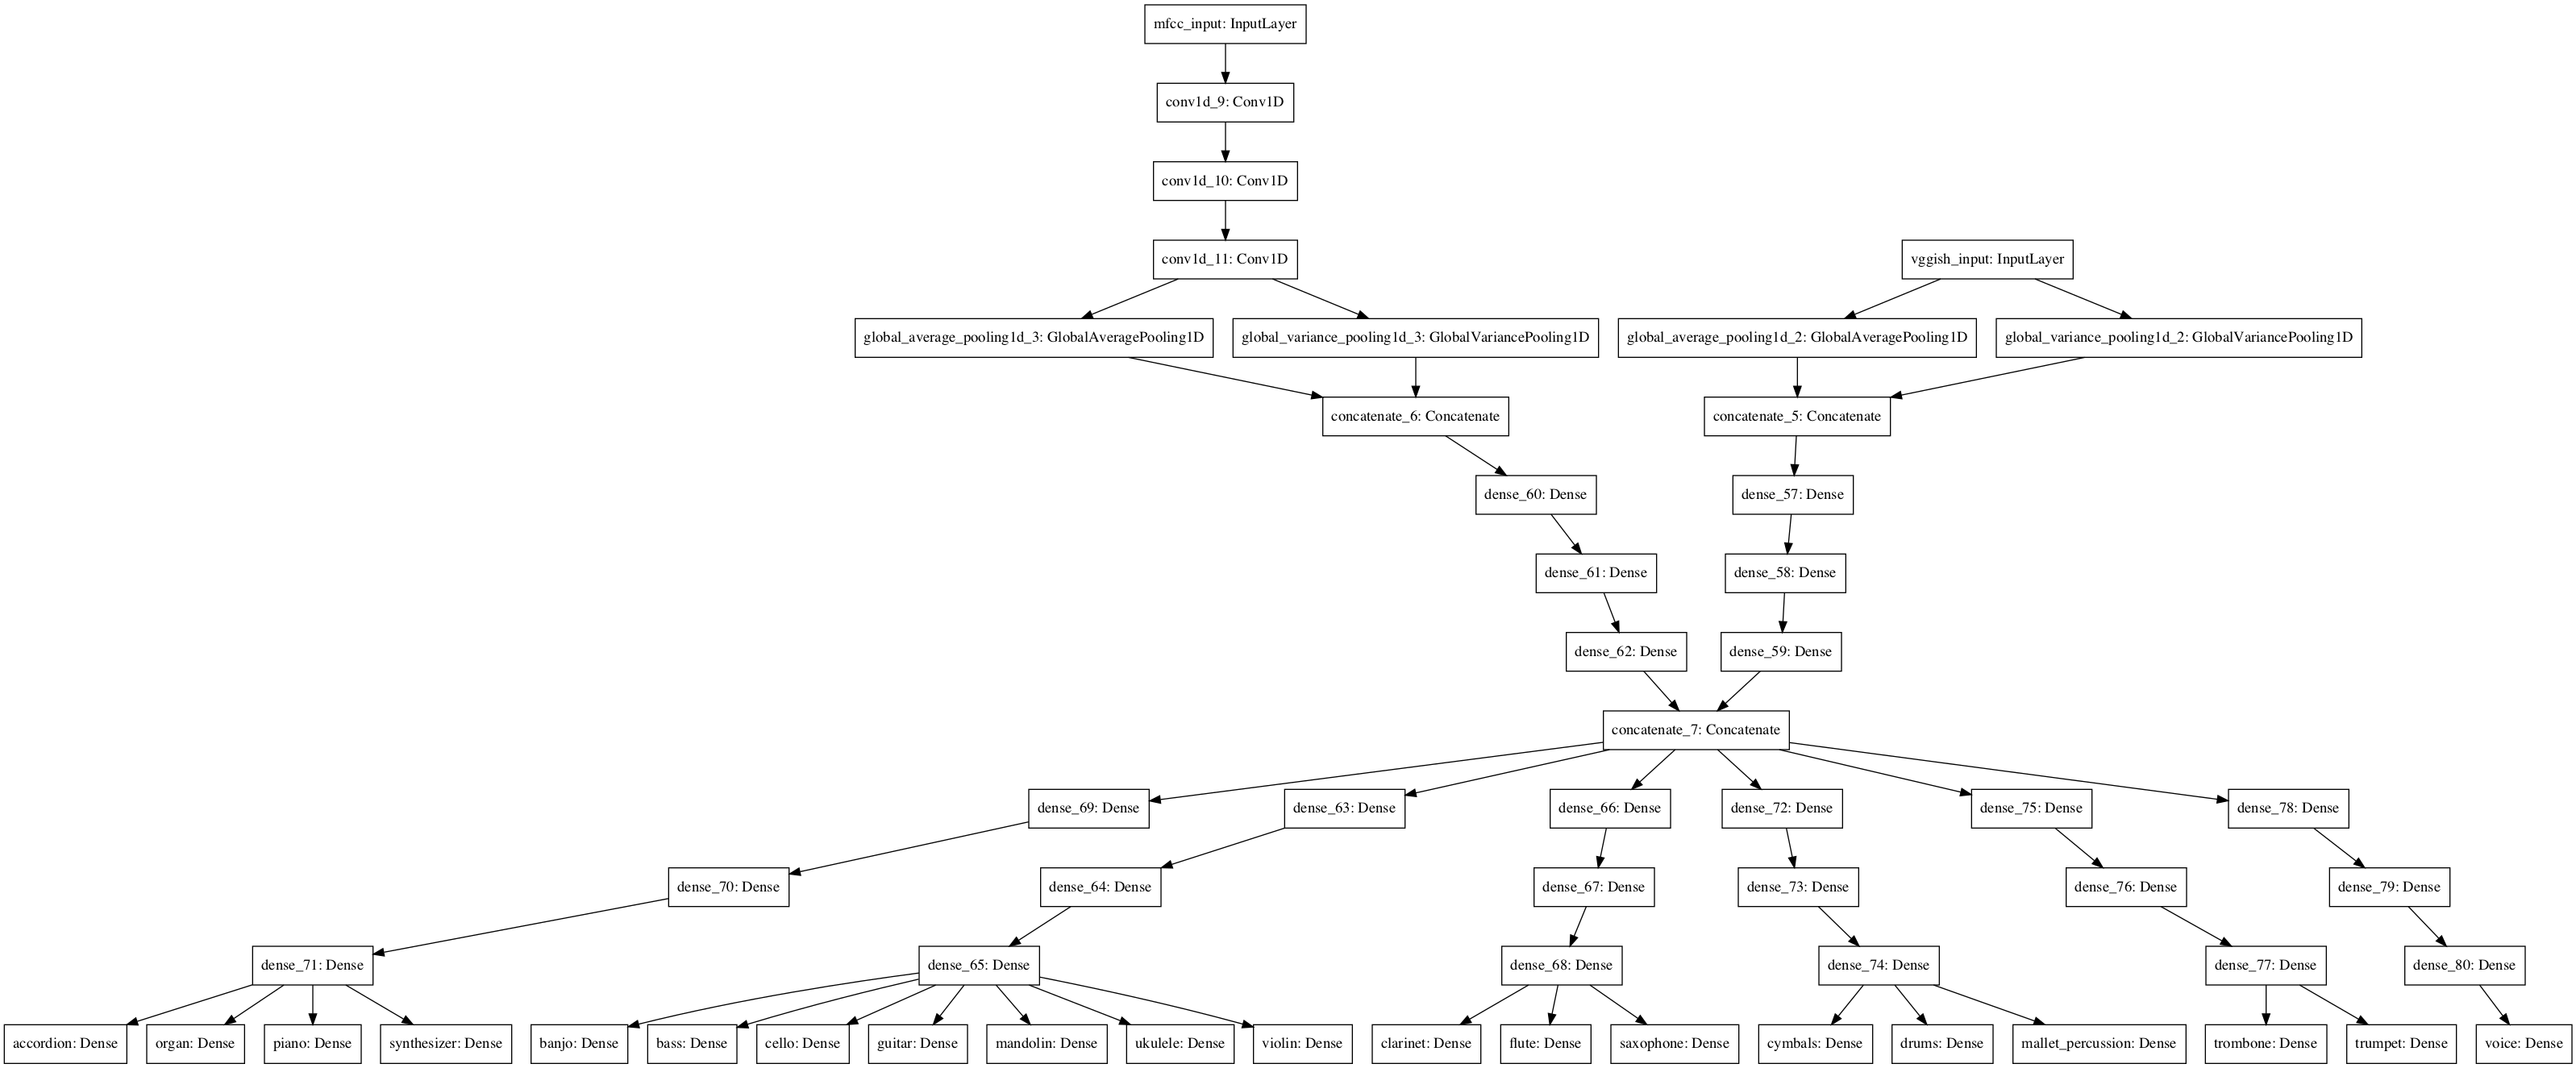

In [42]:
x_vec_branched_nn = create_branched_nn(x_vec=True)
x_vec_branched_nn.summary()

plot_model(x_vec_branched_nn)

In [43]:
callbacks = [
    ModelCheckpoint(filepath='./models/branched.h5'),
    ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(patience=7, restore_best_weights=True)
]

x_vec_branched_nn.fit(branched_train_dataset, validation_data=branched_test_dataset,
                    epochs=1000, callbacks=callbacks,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1)

print('='*117)
print('Results:')

results = x_vec_branched_nn.evaluate(branched_test_dataset, steps=val_steps_per_epoch, verbose=0)
loss = results[0]
mse_results = {key+'_mse': res for key, res in zip(class_map.keys(), results[21:41])}
mae_results = {key+'_mae': res for key, res in zip(class_map.keys(), results[41:61])}
print(f'Total Loss: {loss}')
print('='*117)
print(f'MSE:\n{mse_results}')
print('='*117)
print(f'MAE:\n{mae_results}')

Train for 933 steps, validate for 318 steps
Epoch 1/1000
933/933 [==============================] - 41s 44ms/step - loss: 9188.4776 - accordion_loss: 935.8773 - banjo_loss: 280.8263 - bass_loss: 531.7900 - cello_loss: 370.8095 - clarinet_loss: 786.7430 - cymbals_loss: 255.0670 - drums_loss: 725.6022 - flute_loss: 552.9509 - guitar_loss: 353.2377 - mallet_percussion_loss: 340.7804 - mandolin_loss: 494.1770 - organ_loss: 310.0341 - piano_loss: 499.8562 - saxophone_loss: 404.6360 - synthesizer_loss: 369.6104 - trombone_loss: 393.6945 - trumpet_loss: 415.5376 - ukulele_loss: 316.9955 - violin_loss: 304.5038 - voice_loss: 545.7397 - accordion_mse: 936.6829 - accordion_mae: 12.1770 - banjo_mse: 281.0665 - banjo_mae: 9.7644 - bass_mse: 532.2458 - bass_mae: 9.1612 - cello_mse: 371.1235 - cello_mae: 10.0195 - clarinet_mse: 787.4086 - clarinet_mae: 11.7631 - cymbals_mse: 255.2885 - cymbals_mae: 8.8308 - drums_mse: 726.2301 - drums_mae: 11.5114 - flute_mse: 553.4282 - flute_mae: 11.1944 - guitar_

Epoch 4/1000
933/933 [==============================] - 24s 26ms/step - loss: 18.7326 - accordion_loss: 1.1535 - banjo_loss: 0.9754 - bass_loss: 0.6597 - cello_loss: 0.6148 - clarinet_loss: 1.1235 - cymbals_loss: 0.6382 - drums_loss: 0.8801 - flute_loss: 0.7549 - guitar_loss: 0.8229 - mallet_percussion_loss: 0.5564 - mandolin_loss: 0.8741 - organ_loss: 0.7563 - piano_loss: 1.1637 - saxophone_loss: 0.9402 - synthesizer_loss: 1.1813 - trombone_loss: 0.9433 - trumpet_loss: 1.3273 - ukulele_loss: 0.9396 - violin_loss: 0.9104 - voice_loss: 1.5168 - accordion_mse: 1.1542 - accordion_mae: 0.7779 - banjo_mse: 0.9757 - banjo_mae: 0.6784 - bass_mse: 0.6602 - bass_mae: 0.5963 - cello_mse: 0.6150 - cello_mae: 0.5383 - clarinet_mse: 1.1237 - clarinet_mae: 0.7697 - cymbals_mse: 0.6386 - cymbals_mae: 0.5333 - drums_mse: 0.8772 - drums_mae: 0.6314 - flute_mse: 0.7555 - flute_mae: 0.5954 - guitar_mse: 0.8236 - guitar_mae: 0.6440 - mallet_percussion_mse: 0.5566 - mallet_percussion_mae: 0.4809 - mandolin

Epoch 7/1000
933/933 [==============================] - 24s 26ms/step - loss: 4.0048 - accordion_loss: 0.2428 - banjo_loss: 0.1441 - bass_loss: 0.0627 - cello_loss: 0.0970 - clarinet_loss: 0.1907 - cymbals_loss: 0.1476 - drums_loss: 0.1995 - flute_loss: 0.1516 - guitar_loss: 0.1240 - mallet_percussion_loss: 0.1469 - mandolin_loss: 0.0954 - organ_loss: 0.1063 - piano_loss: 0.2151 - saxophone_loss: 0.2433 - synthesizer_loss: 0.2738 - trombone_loss: 0.3556 - trumpet_loss: 0.4175 - ukulele_loss: 0.0965 - violin_loss: 0.1469 - voice_loss: 0.5475 - accordion_mse: 0.2430 - accordion_mae: 0.3583 - banjo_mse: 0.1443 - banjo_mae: 0.2613 - bass_mse: 0.0628 - bass_mae: 0.1509 - cello_mse: 0.0968 - cello_mae: 0.2024 - clarinet_mse: 0.1908 - clarinet_mae: 0.3126 - cymbals_mse: 0.1477 - cymbals_mae: 0.2631 - drums_mse: 0.1996 - drums_mae: 0.3096 - flute_mse: 0.1517 - flute_mae: 0.2662 - guitar_mse: 0.1240 - guitar_mae: 0.2280 - mallet_percussion_mse: 0.1470 - mallet_percussion_mae: 0.2674 - mandolin_

933/933 [==============================] - 25s 27ms/step - loss: 2.3886 - accordion_loss: 0.1036 - banjo_loss: 0.0848 - bass_loss: 0.0439 - cello_loss: 0.0611 - clarinet_loss: 0.1087 - cymbals_loss: 0.1291 - drums_loss: 0.1736 - flute_loss: 0.1005 - guitar_loss: 0.0832 - mallet_percussion_loss: 0.1295 - mandolin_loss: 0.0554 - organ_loss: 0.0573 - piano_loss: 0.1177 - saxophone_loss: 0.1437 - synthesizer_loss: 0.1232 - trombone_loss: 0.2115 - trumpet_loss: 0.2212 - ukulele_loss: 0.0609 - violin_loss: 0.0798 - voice_loss: 0.2999 - accordion_mse: 0.1037 - accordion_mae: 0.2245 - banjo_mse: 0.0849 - banjo_mae: 0.1926 - bass_mse: 0.0439 - bass_mae: 0.1246 - cello_mse: 0.0611 - cello_mae: 0.1554 - clarinet_mse: 0.1086 - clarinet_mae: 0.2367 - cymbals_mse: 0.1290 - cymbals_mae: 0.2438 - drums_mse: 0.1736 - drums_mae: 0.2961 - flute_mse: 0.1006 - flute_mae: 0.2239 - guitar_mse: 0.0831 - guitar_mae: 0.1806 - mallet_percussion_mse: 0.1296 - mallet_percussion_mae: 0.2554 - mandolin_mse: 0.0555 -

Epoch 12/1000
933/933 [==============================] - 25s 26ms/step - loss: 1.5919 - accordion_loss: 0.0554 - banjo_loss: 0.0689 - bass_loss: 0.0339 - cello_loss: 0.0516 - clarinet_loss: 0.0708 - cymbals_loss: 0.0988 - drums_loss: 0.1043 - flute_loss: 0.0751 - guitar_loss: 0.0725 - mallet_percussion_loss: 0.0805 - mandolin_loss: 0.0459 - organ_loss: 0.0414 - piano_loss: 0.0901 - saxophone_loss: 0.1058 - synthesizer_loss: 0.0768 - trombone_loss: 0.1096 - trumpet_loss: 0.1533 - ukulele_loss: 0.0454 - violin_loss: 0.0608 - voice_loss: 0.1509 - accordion_mse: 0.0554 - accordion_mae: 0.1584 - banjo_mse: 0.0689 - banjo_mae: 0.1735 - bass_mse: 0.0339 - bass_mae: 0.1074 - cello_mse: 0.0516 - cello_mae: 0.1382 - clarinet_mse: 0.0709 - clarinet_mae: 0.1873 - cymbals_mse: 0.0988 - cymbals_mae: 0.2169 - drums_mse: 0.1043 - drums_mae: 0.2273 - flute_mse: 0.0751 - flute_mae: 0.1891 - guitar_mse: 0.0726 - guitar_mae: 0.1712 - mallet_percussion_mse: 0.0806 - mallet_percussion_mae: 0.1926 - mandolin

Epoch 15/1000
933/933 [==============================] - 24s 26ms/step - loss: 1.0565 - accordion_loss: 0.0369 - banjo_loss: 0.0464 - bass_loss: 0.0273 - cello_loss: 0.0409 - clarinet_loss: 0.0418 - cymbals_loss: 0.0621 - drums_loss: 0.0692 - flute_loss: 0.0456 - guitar_loss: 0.0601 - mallet_percussion_loss: 0.0457 - mandolin_loss: 0.0392 - organ_loss: 0.0287 - piano_loss: 0.0684 - saxophone_loss: 0.0685 - synthesizer_loss: 0.0623 - trombone_loss: 0.0615 - trumpet_loss: 0.0872 - ukulele_loss: 0.0370 - violin_loss: 0.0500 - voice_loss: 0.0777 - accordion_mse: 0.0370 - accordion_mae: 0.1139 - banjo_mse: 0.0464 - banjo_mae: 0.1242 - bass_mse: 0.0273 - bass_mae: 0.0818 - cello_mse: 0.0408 - cello_mae: 0.1070 - clarinet_mse: 0.0419 - clarinet_mae: 0.1325 - cymbals_mse: 0.0621 - cymbals_mae: 0.1456 - drums_mse: 0.0692 - drums_mae: 0.1639 - flute_mse: 0.0456 - flute_mae: 0.1331 - guitar_mse: 0.0602 - guitar_mae: 0.1391 - mallet_percussion_mse: 0.0457 - mallet_percussion_mae: 0.1265 - mandolin

Epoch 18/1000
933/933 [==============================] - 24s 25ms/step - loss: 0.8298 - accordion_loss: 0.0226 - banjo_loss: 0.0358 - bass_loss: 0.0242 - cello_loss: 0.0363 - clarinet_loss: 0.0385 - cymbals_loss: 0.0581 - drums_loss: 0.0543 - flute_loss: 0.0288 - guitar_loss: 0.0529 - mallet_percussion_loss: 0.0463 - mandolin_loss: 0.0350 - organ_loss: 0.0287 - piano_loss: 0.0528 - saxophone_loss: 0.0490 - synthesizer_loss: 0.0497 - trombone_loss: 0.0384 - trumpet_loss: 0.0483 - ukulele_loss: 0.0324 - violin_loss: 0.0456 - voice_loss: 0.0522 - accordion_mse: 0.0226 - accordion_mae: 0.0579 - banjo_mse: 0.0358 - banjo_mae: 0.0781 - bass_mse: 0.0242 - bass_mae: 0.0566 - cello_mse: 0.0363 - cello_mae: 0.0775 - clarinet_mse: 0.0385 - clarinet_mae: 0.0616 - cymbals_mse: 0.0582 - cymbals_mae: 0.1090 - drums_mse: 0.0541 - drums_mae: 0.1075 - flute_mse: 0.0286 - flute_mae: 0.0650 - guitar_mse: 0.0529 - guitar_mae: 0.1079 - mallet_percussion_mse: 0.0463 - mallet_percussion_mae: 0.0743 - mandolin

Epoch 21/1000
933/933 [==============================] - 25s 27ms/step - loss: 0.7290 - accordion_loss: 0.0216 - banjo_loss: 0.0323 - bass_loss: 0.0221 - cello_loss: 0.0334 - clarinet_loss: 0.0208 - cymbals_loss: 0.0468 - drums_loss: 0.0450 - flute_loss: 0.0251 - guitar_loss: 0.0509 - mallet_percussion_loss: 0.0296 - mandolin_loss: 0.0344 - organ_loss: 0.0257 - piano_loss: 0.0479 - saxophone_loss: 0.0472 - synthesizer_loss: 0.0479 - trombone_loss: 0.0348 - trumpet_loss: 0.0447 - ukulele_loss: 0.0294 - violin_loss: 0.0444 - voice_loss: 0.0451 - accordion_mse: 0.0216 - accordion_mae: 0.0537 - banjo_mse: 0.0323 - banjo_mae: 0.0742 - bass_mse: 0.0221 - bass_mae: 0.0535 - cello_mse: 0.0334 - cello_mae: 0.0771 - clarinet_mse: 0.0208 - clarinet_mae: 0.0554 - cymbals_mse: 0.0469 - cymbals_mae: 0.1009 - drums_mse: 0.0450 - drums_mae: 0.1018 - flute_mse: 0.0251 - flute_mae: 0.0589 - guitar_mse: 0.0510 - guitar_mae: 0.1044 - mallet_percussion_mse: 0.0297 - mallet_percussion_mae: 0.0666 - mandolin

Epoch 24/1000
933/933 [==============================] - 25s 27ms/step - loss: 0.7062 - accordion_loss: 0.0209 - banjo_loss: 0.0320 - bass_loss: 0.0207 - cello_loss: 0.0332 - clarinet_loss: 0.0203 - cymbals_loss: 0.0453 - drums_loss: 0.0414 - flute_loss: 0.0244 - guitar_loss: 0.0502 - mallet_percussion_loss: 0.0295 - mandolin_loss: 0.0343 - organ_loss: 0.0270 - piano_loss: 0.0397 - saxophone_loss: 0.0463 - synthesizer_loss: 0.0459 - trombone_loss: 0.0345 - trumpet_loss: 0.0437 - ukulele_loss: 0.0293 - violin_loss: 0.0435 - voice_loss: 0.0441 - accordion_mse: 0.0210 - accordion_mae: 0.0516 - banjo_mse: 0.0320 - banjo_mae: 0.0746 - bass_mse: 0.0208 - bass_mae: 0.0541 - cello_mse: 0.0332 - cello_mae: 0.0765 - clarinet_mse: 0.0203 - clarinet_mae: 0.0543 - cymbals_mse: 0.0453 - cymbals_mae: 0.0979 - drums_mse: 0.0414 - drums_mae: 0.0940 - flute_mse: 0.0244 - flute_mae: 0.0591 - guitar_mse: 0.0503 - guitar_mae: 0.1044 - mallet_percussion_mse: 0.0295 - mallet_percussion_mae: 0.0666 - mandolin

Epoch 27/1000
933/933 [==============================] - 25s 27ms/step - loss: 0.6831 - accordion_loss: 0.0208 - banjo_loss: 0.0318 - bass_loss: 0.0197 - cello_loss: 0.0331 - clarinet_loss: 0.0199 - cymbals_loss: 0.0425 - drums_loss: 0.0390 - flute_loss: 0.0239 - guitar_loss: 0.0490 - mallet_percussion_loss: 0.0291 - mandolin_loss: 0.0339 - organ_loss: 0.0276 - piano_loss: 0.0341 - saxophone_loss: 0.0450 - synthesizer_loss: 0.0433 - trombone_loss: 0.0337 - trumpet_loss: 0.0426 - ukulele_loss: 0.0287 - violin_loss: 0.0427 - voice_loss: 0.0426 - accordion_mse: 0.0208 - accordion_mae: 0.0530 - banjo_mse: 0.0318 - banjo_mae: 0.0745 - bass_mse: 0.0198 - bass_mae: 0.0506 - cello_mse: 0.0329 - cello_mae: 0.0776 - clarinet_mse: 0.0200 - clarinet_mae: 0.0526 - cymbals_mse: 0.0426 - cymbals_mae: 0.0950 - drums_mse: 0.0391 - drums_mae: 0.0863 - flute_mse: 0.0239 - flute_mae: 0.0580 - guitar_mse: 0.0490 - guitar_mae: 0.1036 - mallet_percussion_mse: 0.0291 - mallet_percussion_mae: 0.0665 - mandolin

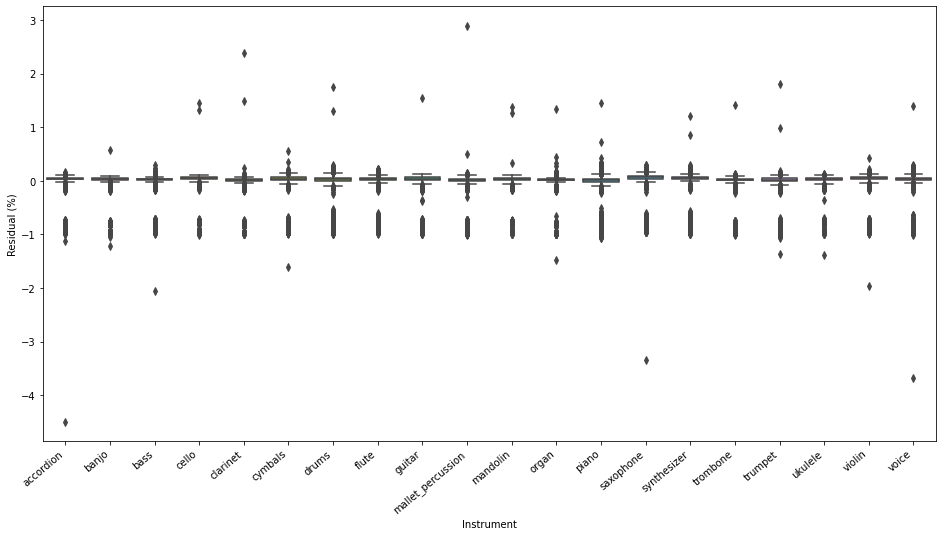

In [44]:
x_vec_branched_df = get_residuals(x_vec_branched_nn, branched_eval_dataset)
plot_residuals(x_vec_branched_df)

In [45]:
x_vec_branched_df.describe()

,accordion,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,mallet_percussion,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
count,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000
mean,0.020605,0.004932,0.006294,0.009853,-0.008028,-0.006163,-0.008597,0.005368,-0.005879,-0.015259,-0.002513,-0.002163,-0.029425,0.017655,0.006885,-0.018772,-0.033815,-0.004270,-0.020954,0.008829
std,0.152230,0.153526,0.147351,0.194587,0.148113,0.223129,0.210673,0.161723,0.225590,0.189984,0.174124,0.143911,0.214074,0.226663,0.212553,0.192320,0.225763,0.169830,0.253847,0.206060
min,-4.490293,-1.223991,-2.046989,-1.011513,-0.997514,-1.610416,-0.989260,-0.993368,-0.999763,-1.014256,-1.000081,-1.482172,-1.074082,-3.347043,-0.991038,-1.013705,-1.360488,-1.390660,-1.960497,-3.668793
25%,0.027360,0.019655,0.017065,0.032511,0.004239,0.016319,0.000098,0.015262,0.019252,0.000371,0.009487,0.008881,-0.017350,0.043555,0.029261,0.007882,-0.001892,0.007837,0.026859,0.022229
50%,0.043365,0.034320,0.027998,0.052312,0.018308,0.035040,0.025623,0.030754,0.042338,0.019016,0.032589,0.015450,0.014186,0.065809,0.045610,0.024814,0.022655,0.027254,0.051354,0.041292
75%,0.059464,0.046254,0.042034,0.068809,0.030318,0.069961,0.062326,0.049762,0.071693,0.041946,0.053409,0.029456,0.039767,0.092538,0.069901,0.038728,0.046181,0.048534,0.069725,0.062422
max,0.170670,0.582293,0.300746,1.459729,2.385372,0.561425,1.747249,0.222547,1.537616,2.883967,1.379672,1.346163,1.452477,0.302498,1.217074,1.419433,1.797726,0.125411,0.418518,1.394677


In [46]:
x_vec_branched_df.melt().describe()

,value
count,101700.000000
mean,-0.003771
std,0.194496
min,-4.490293
25%,0.012716
50%,0.032709
75%,0.055424
max,2.883967


In [47]:
f = scipy.stats.f_oneway(x_vec_branched_df, branched_df)
f_stat_by_class = f[0]
p_vals = f[1]
pprint(f_stat_by_class)
pprint(p_vals)

array([4.48244925e+01, 2.77272239e+01, 2.67823222e+01, 3.23333266e+01,
       4.14639454e+00, 3.38968843e+00, 4.19834516e-02, 1.75720316e+01,
       8.86879308e+00, 1.17740551e+00, 2.32187499e-01, 5.95298697e-01,
       5.37345067e+01, 4.64076121e+00, 2.18219951e+01, 6.68646096e+00,
       2.80370304e-01, 1.10568320e+00, 2.47829061e+00, 4.92267336e+01])
array([2.26884785e-11, 1.42534900e-07, 2.32055918e-07, 1.33449987e-08,
       4.17491346e-02, 6.56344594e-02, 8.37655421e-01, 2.78968813e-05,
       2.90771212e-03, 2.77910542e-01, 6.29916924e-01, 4.40395359e-01,
       2.46964970e-13, 3.12445712e-02, 3.02988316e-06, 9.72856412e-03,
       5.96470169e-01, 2.93047243e-01, 1.15458754e-01, 2.42554021e-12])


In [48]:
sig_95 = p_vals < 0.05
sig_90 = p_vals < 0.1

print("Classes improved with 95% confidence: ", len(branched_df.columns[sig_95]))
print("Classes improved with 90% confidence: ", len(branched_df.columns[sig_90]))

Classes improved with 95% confidence:  12
Classes improved with 90% confidence:  13


In [49]:
pprint(list(branched_df.columns[~sig_95]))
pprint(list(branched_df.columns[~sig_90]))

['cymbals',
 'drums',
 'mallet_percussion',
 'mandolin',
 'organ',
 'trumpet',
 'ukulele',
 'violin']
['drums',
 'mallet_percussion',
 'mandolin',
 'organ',
 'trumpet',
 'ukulele',
 'violin']


In [50]:
pprint(list(branched_df.columns[sig_95]))
pprint(list(branched_df.columns[sig_90]))

['accordion',
 'banjo',
 'bass',
 'cello',
 'clarinet',
 'flute',
 'guitar',
 'piano',
 'saxophone',
 'synthesizer',
 'trombone',
 'voice']
['accordion',
 'banjo',
 'bass',
 'cello',
 'clarinet',
 'cymbals',
 'flute',
 'guitar',
 'piano',
 'saxophone',
 'synthesizer',
 'trombone',
 'voice']
